<a id='1'></a>
# Import packages

python3 FaceSwap_GAN_v2.2_train_test.py -iA ./faces/wdx/aligned_faces/ -iB ./faces/ccj/aligned_faces/ -eA ./faces/wdx/binary_masks_eyes/ -eB ./faces/ccj/binary_masks_eyes/ -md ./results/wdx_ccj/models -sd ./results/wdx_ccj/samples -mb True -gpu 2

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import tensorflow as tf
import keras.backend as K
import os
import cv2
import glob
import time
import matplotlib.pyplot as plt
from keras.layers import *
from pathlib import PurePath, Path
from tqdm import tqdm

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

config = tf.ConfigProto()  
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)

Using TensorFlow backend.


<a id='4'></a>
# Config

In [2]:
# Number of CPU cores
num_cpus = os.cpu_count()

# Input/Output resolution
RESOLUTION = 64 # 64x64, 128x128, 256x256
assert (RESOLUTION % 64) == 0, "RESOLUTION should be 64, 128, or 256."

# Batch size
batchSize = 8

# Use motion blurs (data augmentation)
# set True if training data contains images extracted from videos
use_da_motion_blur = False 

# Use eye-aware training
# require images generated from prep_binary_masks.ipynb
use_bm_eyes = True

# Probability of random color matching (data augmentation)
prob_random_color_match = 0.5

da_config = {
    "prob_random_color_match": prob_random_color_match,
    "use_da_motion_blur": use_da_motion_blur,
    "use_bm_eyes": use_bm_eyes
}

In [3]:
# Architecture configuration
arch_config = {}
arch_config['IMAGE_SHAPE'] = (RESOLUTION, RESOLUTION, 3)
arch_config['use_self_attn'] = True
arch_config['norm'] = "instancenorm" # instancenorm, batchnorm, layernorm, groupnorm, none
arch_config['model_capacity'] = "standard" # standard, lite

In [4]:
K.set_learning_phase(1)

# Loss function weights configuration
loss_weights = {}
loss_weights['w_D'] = 0.1 # Discriminator
loss_weights['w_recon'] = 1. # L1 reconstruction loss
loss_weights['w_edge'] = 0.1 # edge loss
loss_weights['w_eyes'] = 30. # reconstruction and edge loss on eyes area
loss_weights['w_pl'] = (0.01, 0.1, 0.3, 0.1) # perceptual loss (0.003, 0.03, 0.3, 0.3)

# Init. loss config.
loss_config = {}
loss_config["gan_training"] = "mixup_LSGAN" # "mixup_LSGAN" or "relativistic_avg_LSGAN"
loss_config['use_PL'] = True
loss_config['use_mask_hinge_loss'] = False
loss_config['m_mask'] = 0.
loss_config['lr_factor'] = 1.
loss_config['use_cyclic_loss'] = False

In [5]:
# Path to training images
img_dirA = './faces/ccj/aligned_faces/'
img_dirB = './faces/leo/aligned_faces/'
img_dirA_bm_eyes = "./faces/ccj/binary_masks_eyes/"
img_dirB_bm_eyes = "./faces/leo/binary_masks_eyes/"

# Path to saved model weights
models_dir = "./models"
Path(models_dir).mkdir(parents=True, exist_ok=True)
samples_dir = "./samples"
Path(samples_dir).mkdir(parents=True, exist_ok=True)

<a id='5'></a>
# Define models

In [6]:
from networks.faceswap_gan_model import FaceswapGANModel
from keras_vggface.vggface import VGGFace

model = FaceswapGANModel(**arch_config)

# VGGFace
vggface = VGGFace(include_top=False, model='resnet50', input_shape=(224, 224, 3))
model.build_pl_model(vggface_model=vggface)

model.build_train_functions(loss_weights=loss_weights, **loss_config)

<a id='5'></a>
# Define data_geneator and load images

In [7]:
# Get filenames
train_A = glob.glob(img_dirA+"/*.*g")
train_B = glob.glob(img_dirB+"/*.*g")

train_AnB = train_A + train_B

assert len(train_A), "No image found in " + str(img_dirA)
assert len(train_B), "No image found in " + str(img_dirB)
print ("Number of images in folder A: " + str(len(train_A)))
print ("Number of images in folder B: " + str(len(train_B)))

if use_bm_eyes:
    assert len(glob.glob(img_dirA_bm_eyes+"/*.*g")), "No binary mask found in " + str(img_dirA_bm_eyes)
    assert len(glob.glob(img_dirB_bm_eyes+"/*.*g")), "No binary mask found in " + str(img_dirB_bm_eyes)
    assert len(glob.glob(img_dirA_bm_eyes+"/*.*g")) == len(train_A), \
    "Number of faceA images does not match number of their binary masks. Can be caused by any none image file in the folder."
    assert len(glob.glob(img_dirB_bm_eyes+"/*.*g")) == len(train_B), \
    "Number of faceB images does not match number of their binary masks. Can be caused by any none image file in the folder."

Number of images in folder A: 12307
Number of images in folder B: 15481


In [8]:
from utils import showG, showG_mask, showG_eyes
from mxnet.gluon.data import Dataset, DataLoader
import sys
sys.path.append('./data_loader/')
from data_augmentation import *
from functools import partial

class FaceSwapDataset(Dataset):
    def __init__(self, filenames, all_filenames, dir_bm_eyes, 
                 resolution, **da_config):
        self.filenames = filenames
        self.all_filenames = all_filenames
        self.dir_bm_eyes = dir_bm_eyes
        self.resolution = resolution
        
        self.set_data_augm_config(
            da_config["prob_random_color_match"], 
            da_config["use_da_motion_blur"], 
            da_config["use_bm_eyes"])
        
    def set_data_augm_config(self, prob_random_color_match=0.5, 
                             use_da_motion_blur=True, use_bm_eyes=True):
        self.prob_random_color_match = prob_random_color_match
        self.use_da_motion_blur = use_da_motion_blur
        self.use_bm_eyes = use_bm_eyes
        
    def __getitem__(self,idx):
        img=read_image(self.filenames[idx],
                       self.all_filenames,
                       self.dir_bm_eyes,
                       self.resolution,
                       self.prob_random_color_match,
                       self.use_da_motion_blur,
                       self.use_bm_eyes)
        return img
    
    def __len__(self):
        return len(self.filenames)
    
class DataLoaderWrapper(object):
    def __init__(self,data_loader,**kwargs):
        self.data_loader=data_loader
        self._gen=self.__gen__()
        
    def get_next_batch(self):
        return next(self._gen)
    
    def __gen__(self):
        while True:
            for i in self.data_loader:
                yield i
    
def mp_batchify_fn(data):
    if isinstance(data[0], tuple):
        data = zip(*data)
        return [mp_batchify_fn(i) for i in data]
    else:
        return np.asarray(data)

# Display random binary masks of eyes
train_setA=FaceSwapDataset(train_A, train_AnB, img_dirA_bm_eyes, 
                           RESOLUTION, **da_config)
train_setB=FaceSwapDataset(train_B, train_AnB, img_dirB_bm_eyes, 
                           RESOLUTION, **da_config)
_DataLoader=partial(DataLoader,batch_size=batchSize,shuffle=True,
                    last_batch='rollover',num_workers=8,batchify_fn=mp_batchify_fn)
train_batchA = DataLoaderWrapper(_DataLoader(train_setA))
train_batchB = DataLoaderWrapper(_DataLoader(train_setB))

(256, 768, 3)


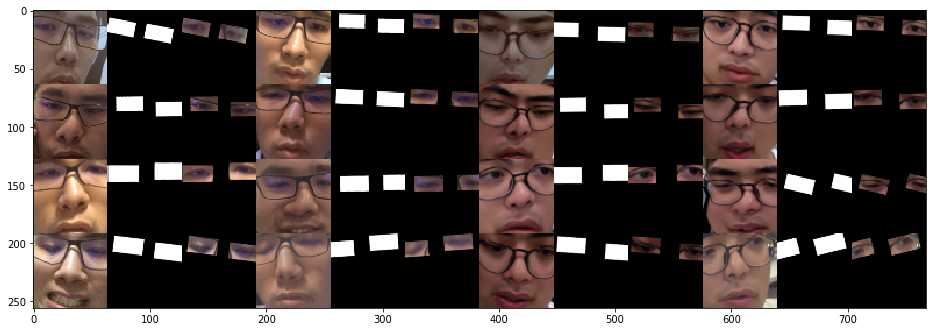

In [9]:
tA, _, bmA = train_batchA.get_next_batch()
tB, _, bmB = train_batchB.get_next_batch()
img=showG_eyes(tA, tB, bmA, bmB, batchSize)
print(img.shape)
plt.figure(figsize=(16,8))
plt.imshow(img)
plt.show()

<a id='10'></a>
# Start Training

In [ ]:
# Start training
t0 = time.time()
gen_iterations = 0
errGA_sum = errGB_sum = errDA_sum = errDB_sum = 0
errGAs = {}
errGBs = {}
# Dictionaries are ordered in Python 3.6
for k in ['ttl', 'adv', 'recon', 'edge', 'pl']:
    errGAs[k] = 0
    errGBs[k] = 0

display_iters = 1000
backup_iters = 5000
TOTAL_ITERS = 40000

with tqdm(total=TOTAL_ITERS,desc='Training') as pbar:
    while gen_iterations <= TOTAL_ITERS:     
        # Train dicriminators for one batch
        data_A = train_batchA.get_next_batch()
        data_B = train_batchB.get_next_batch()
        errDA, errDB = model.train_one_batch_D(data_A=data_A, data_B=data_B)
        errDA_sum +=errDA[0]
        errDB_sum +=errDB[0]

        # Train generators for one batch
        data_A = train_batchA.get_next_batch()
        data_B = train_batchB.get_next_batch()
        errGA, errGB = model.train_one_batch_G(data_A=data_A, data_B=data_B)
        errGA_sum += errGA[0]
        errGB_sum += errGB[0]
        for i, k in enumerate(['ttl', 'adv', 'recon', 'edge', 'pl']):
            errGAs[k] += errGA[i]
            errGBs[k] += errGB[i]
        gen_iterations+=1

        # Visualization
        if gen_iterations % display_iters == 0:
            # Display loss information
    #         show_loss_config(loss_config)
            print("----------") 
            print('[iter %d] Loss_DA: %f Loss_DB: %f Loss_GA: %f Loss_GB: %f time: %f'
            % (gen_iterations, errDA_sum/display_iters, errDB_sum/display_iters,
               errGA_sum/display_iters, errGB_sum/display_iters, time.time()-t0))  
            print("----------") 
            print("Generator loss details:")
            print(f'[Adversarial loss]')  
            print(f'GA: {errGAs["adv"]/display_iters:.4f} GB: {errGBs["adv"]/display_iters:.4f}')
            print(f'[Reconstruction loss]')
            print(f'GA: {errGAs["recon"]/display_iters:.4f} GB: {errGBs["recon"]/display_iters:.4f}')
            print(f'[Edge loss]')
            print(f'GA: {errGAs["edge"]/display_iters:.4f} GB: {errGBs["edge"]/display_iters:.4f}')
            if loss_config['use_PL'] == True:
                print(f'[Perceptual loss]')
                try:
                    print(f'GA: {errGAs["pl"][0]/display_iters:.4f} GB: {errGBs["pl"][0]/display_iters:.4f}')
                except:
                    print(f'GA: {errGAs["pl"]/display_iters:.4f} GB: {errGBs["pl"]/display_iters:.4f}')

            # Display images
            print("----------") 
            wA, tA, _ = train_batchA.get_next_batch()
            wB, tB, _ = train_batchB.get_next_batch()
#             print("Transformed (masked) results:")
            img=showG(tA, tB, model.path_A, model.path_B, batchSize)
            plt.imsave(os.path.join(samples_dir,'result_%05d.jpg'%gen_iterations),img)
#             print("Masks:")
            img=showG_mask(tA, tB, model.path_mask_A, model.path_mask_B, batchSize)  
            plt.imsave(os.path.join(samples_dir,'mask_%05d.jpg'%gen_iterations),img)
#             print("Reconstruction results:")
#             showG(wA, wB, model.path_bgr_A, model.path_bgr_B, batchSize)      

            # Reset statistic
            errGA_sum = errGB_sum = errDA_sum = errDB_sum = 0
            for k in ['ttl', 'adv', 'recon', 'edge', 'pl']:
                errGAs[k] = 0
                errGBs[k] = 0

            # Save models
            save_dir=os.path.join(models_dir,'%05d'%gen_iterations)
            os.makedirs(save_dir,exist_ok=True)
            model.save_weights(path=save_dir)

        # Backup models
        if gen_iterations % backup_iters == 0: 
            bkup_dir = f"{models_dir}/backup_iter{gen_iterations}"
            Path(bkup_dir).mkdir(parents=True, exist_ok=True)
            model.save_weights(path=bkup_dir)
            
        pbar.update()